## MNIST Fashion dataset

In [1]:
#GPU Run

# import the necessary packages
import imageio
import glob
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import backend as K

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    # Block 1
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block 2
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block 3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block 4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Final Block
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(2, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [5]:
def decoder(input_decoder):
    # Initial Block
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = tf.reshape(x, [-1, 7, 7, 64], name='Reshape_Layer')

    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides=1, padding='same', name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block 3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block 4
    outputs = layers.Conv2DTranspose(1, 3, 1, padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [7]:
enc = encoder(input_encoder=(28, 28, 1))
dec = decoder(input_decoder=(2,))

combined_model = tf.keras.Sequential([enc, dec])

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)


In [8]:
def ae_loss(y_true, y_pred):
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

In [9]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)

    gradients = tape.gradient(loss, combined_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, combined_model.trainable_variables))
    return loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

In [10]:
train(train_dataset, epochs=5)

2023-06-10 19:38:20.859531: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-06-10 19:38:20.859699: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]


Time for epoch 1 is 48.74856615066528 sec
Time for epoch 2 is 50.808079957962036 sec
Time for epoch 3 is 53.974143981933594 sec
Time for epoch 4 is 56.62162494659424 sec
Time for epoch 5 is 56.19928503036499 sec


1/1 [==============================] - 0s 65ms/step


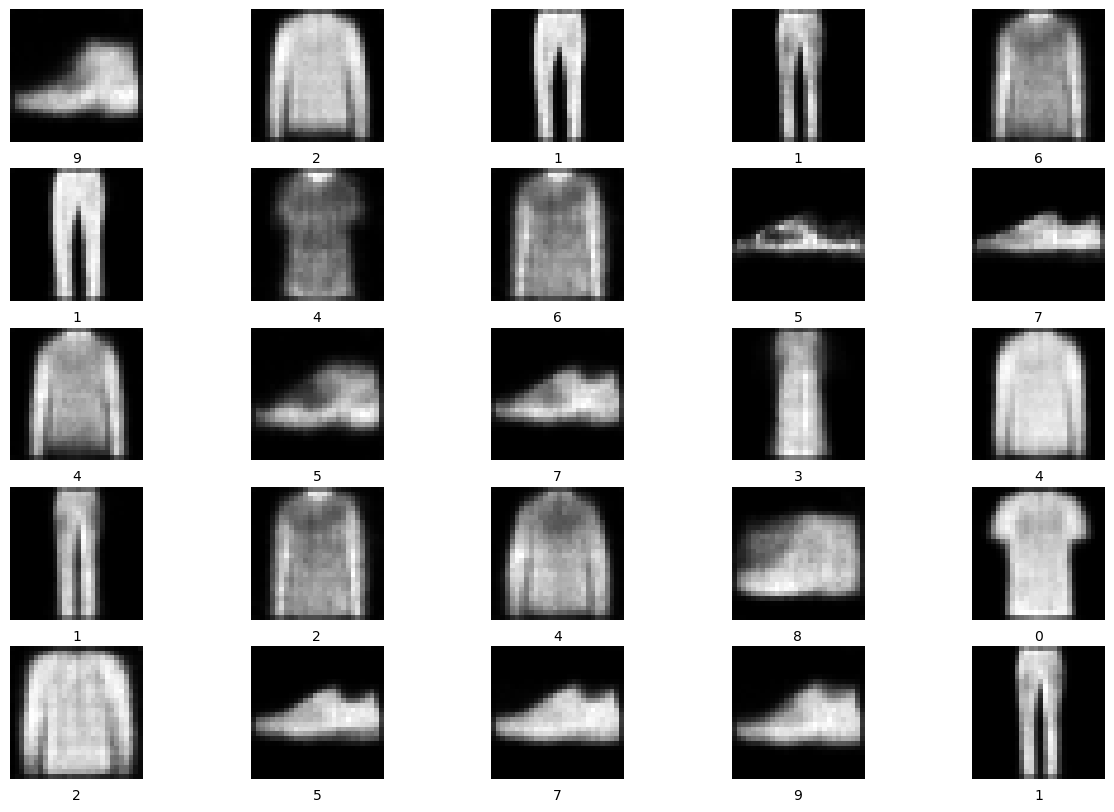

In [11]:
figsize = 15

latent = enc.predict(x_test[:25])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(y_test[i]), fontsize=10, ha='center', transform=ax.transAxes)

    ax.imshow(reconst[i, :, :, 0] * 255, cmap='gray')

157/157 [==============================] - 1s 5ms/step


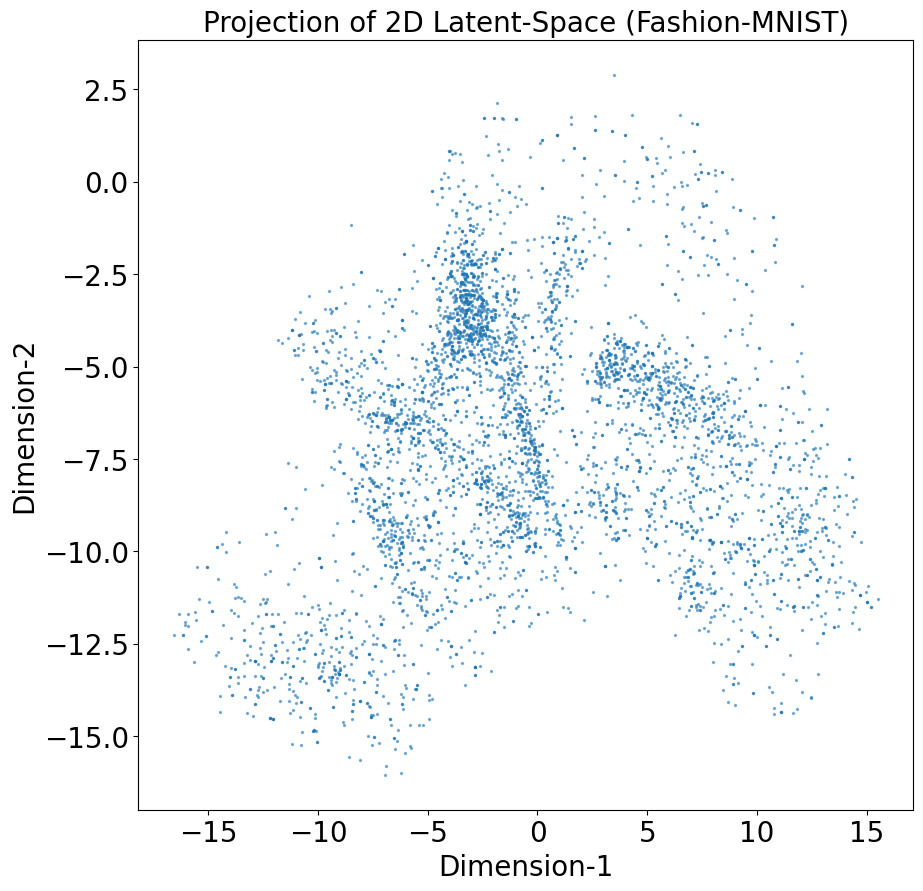

In [12]:
imgs_visualize = 5000
figsize = 10
 
index = np.random.choice(range(len(x_test)), imgs_visualize)
images = x_test[index]
 
embeddings = enc.predict(images)
 
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

1/1 [==============================] - 0s 19ms/step


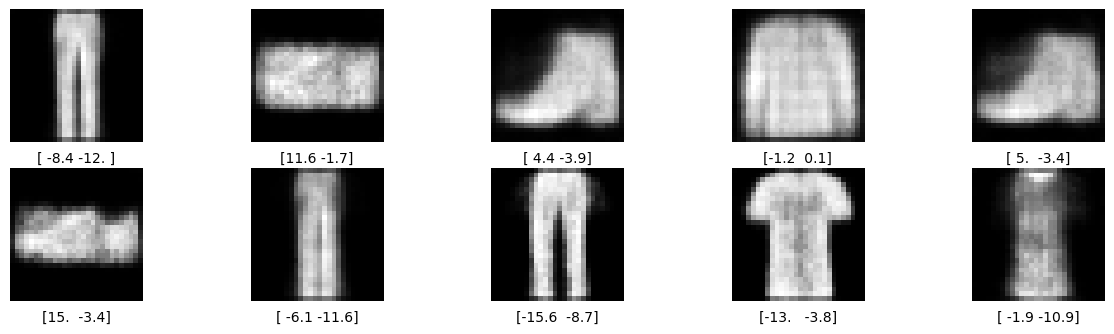

In [13]:
min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])
 
x = np.random.uniform(low=min_x,high=max_x, size = (10,1))
y = np.random.uniform(low=min_y,high=max_y, size = (10,1))
bottleneck = np.concatenate((x, y), axis=1)
reconst = dec.predict(bottleneck)
 
fig = plt.figure(figsize=(15, 10))
 
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(bottleneck[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
     
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

## Cartoon dataset

In [2]:
import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'cartoonset100k',
  image_size=(256, 256),
  batch_size=128,
  label_mode=None)
 
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
 
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Found 100000 files belonging to 1 classes.


In [4]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block 1
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block 2
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 3
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block 4
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block 5
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)

    # Final Block
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(200, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model


In [5]:
def decoder(input_decoder):
    # Initial Block
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer')
     
    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block 4  
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    # Block 5 
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [6]:
# Encoder model
encoder_model = encoder((256, 256, 3))

# Decoder model
decoder_model = decoder((200,))

In [ ]:
reconstruction = []
lat_space = []

for i in normalized_ds:
    latent = encoder_model.predict(i)
    out = decoder_model.predict(latent)
    reconstruction.append(out)
    lat_space.append(latent)
    if len(reconstruction) > 50: #all'inizio era 5000, ma ho dovuto ridurlo per la memoria 
        break

reconstruction = np.concatenate(reconstruction)
lat_space = np.concatenate(lat_space)

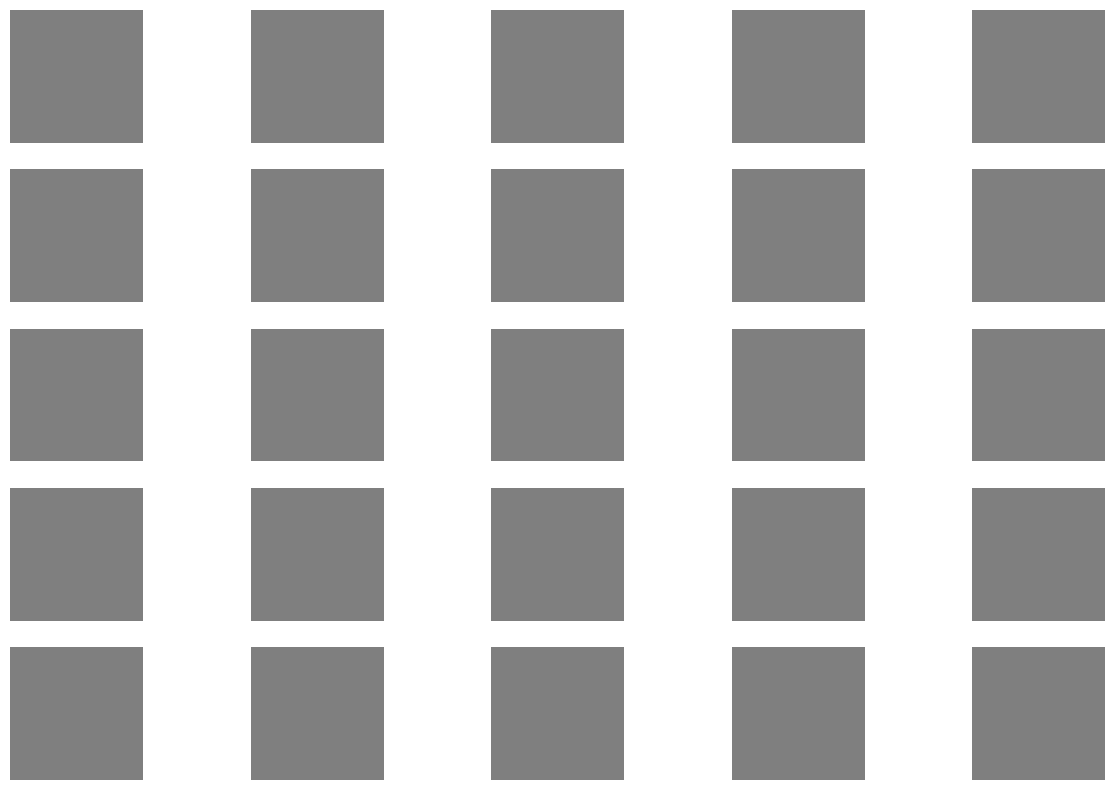

In [8]:
figsize = 15
fig = plt.figure(figsize=(figsize, 10))
 
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

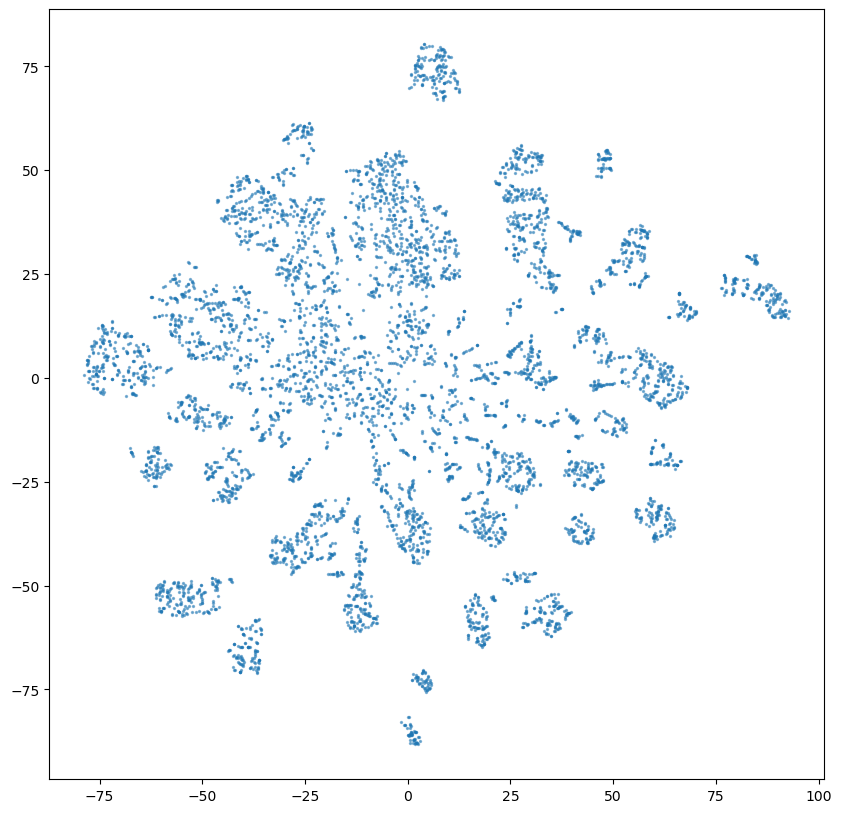

In [13]:
from sklearn.manifold import TSNE

figsize = 10
embeddings = lat_space 

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
 
plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.show()

(10, 1)
1/1 [==============================] - 0s 165ms/step


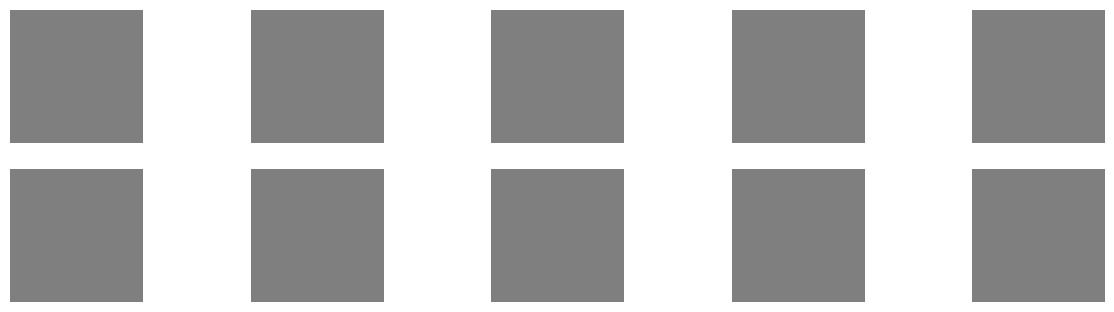

In [28]:
figsize = 15
 
min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
x = np.array([np.random.uniform(low=min_x[i], high=max_x[i]) for i in range(10)]).reshape(10, 1)


input = np.random.uniform(size = (10,200))
bottleneck = x * (max_x - (np.abs(min_x))) 
print(x.shape)
reconstruct = decoder_model.predict(bottleneck)
 
fig = plt.figure(figsize=(figsize, 10))
 
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

1/1 [==============================] - 0s 91ms/step


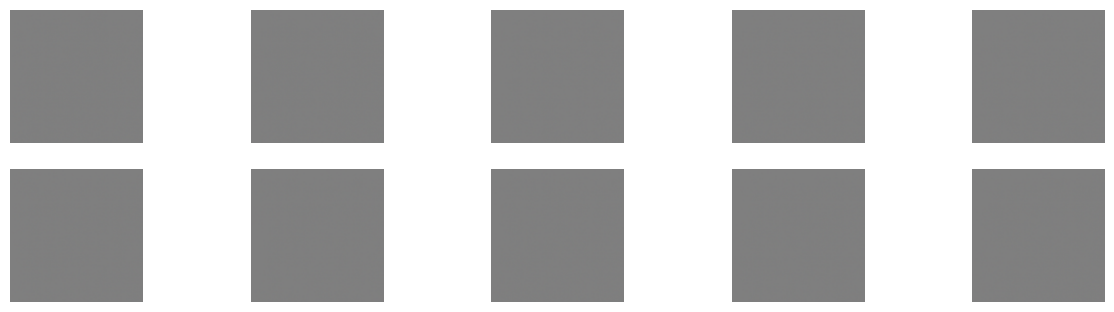

In [30]:
x = np.random.normal(size = (10,200))
reconstruct = decoder_model.predict(x)
 
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
 
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)